##### RESOURCE: https://medium.com/@jacobbumgarner/breaking-it-down-logistic-regression-e5c3f1450bd#cee3

In [1]:
import numpy as np

from celluloid import Camera

import matplotlib.pyplot as plt


In [2]:
class LogisticRegression:
    """
    Description:
        Logistic Regression
    Args:
        n_input_features (int): # of features in the dataset
    Attirbutes:
        weights (np.ndarray)
        bias (float)
        fit (bool): Whether the model has been fit or not to training data. Default: False
    
    """
    
    def __init__(self, n_input_features: int):
        """
        Description:
            Initialize weights (W) and bias (b)    
        """
        self.weights = np.random.randn(n_input_features,1)*0.01 # Do not start with zeros. Font: Andrew NG course
        self.bias = np.zeros((1,1))
        
        self.fit = False # indicates the training state of the classifier
        
    
    def linear_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Description:
            Linear component
            Z = W X + b
        
        Args:
            X (np.ndarray): Input data
        
        Returns:
            np.ndarray: transformed data Z
        
        W -> weights
        b -> bias
        X -> Input data
        """
        return np.matmul(X, self.weights) + self.bias # np.matmul = matrix multiplication line vs colunm
    
    def sigmoid(self, Z: np.ndarray) -> np.ndarray:
        """
        Description:
            Sigmoid function
            sigma(z) = 1 / (1 + exp(-z))
        
        Args:
            Z (np.ndarray): Linear transformed data
        
        Returns:
            np.ndarray: Data evaluated in a sigmoid function
        """
        return 1. / (1. + np.exp(-Z))
        
    
    def cost_cross_entropy(self, A: np.ndarray, Y: np.ndarray) -> float:
        """
        Description:
            Cross-Entropy Cost Function
            L(Y,A) = (1/m) \sum_n [(-Y log(A)) - (1-Y)(log(1-A))]
            
        Args:
            Y (np.ndarray): true label of the data
            A (np.ndarray): label "probability" 
        """
        m = Y.shape[0]
        epsilon = 1e-6
        
        cost = (-1/m) * np.sum( Y*np.log(A)  + \
                (1 - Y) * np.log(1-A+epsilon))
        
        # cost = np.squeeze(cost) make sure cost is in the correct shape (turn [[1]] into 1)
        return np.squeeze(cost)
    
    def gradient_descent(self, X: np.ndarray, A: np.ndarray, Y: np.ndarray,
                        learning_rate = 0.01) -> None:
        """
        Description:
            Compute the Gradient Descent
            dZ = (A - Y)
            dW = dZ . X 
            dB = dZ
                and update
            W = W - dW * learning_rate
            b = b - dB * learning_rate
        """
        m = A.shape[0]
        oneover_m = 1./m
        
        dZ = (A - Y)
        dW = np.mean(dZ * X, axis=0, keepdims=True).T
        dB = np.mean(dZ, axis=0, keepdims=True).T
        
#         dW = (oneover_m * np.sum( dZ * X)).T
#         dB = (oneover_m * np.sum( dZ )).T
        
        # Update
        self.weights -= dW * learning_rate
        self.bias -= dB * learning_rate
        
        return
        
        
    def train(self, X: np.ndarray, Y: np.ndarray,
             epochs: int = 100, learning_rate: float = 0.01, batch_size: int = 10,
             verbose: bool = False) -> np.ndarray:
        
        """
        Description:
            Fit the logistic regression model to training data
            Use minibatch GD.
            
        Args:
            X (np.ndarray): Training dataset
            Y (np.ndarray): Training targets
            epochs (int, optional; default = 100): Number of iterations
            learning_rate (float, optional; default = 0.01): Learning rate step size
            batch_size (int, optional; default = 10): Size of batch for GD
            verbose (bool, optional; default = False): __description__
        
        Raises:
            Attribute: Raises error if the model is already fitted
            ValueError: Raises error if the number of features dosen't match the instantiated feature count.
            
        Returns:
            np.ndarray: The cost history
        
        """
        # Raise flags
        if self.fit:
            raise AttributeError("Error: Model already fitted")
        self.fit = True
        
        if not X.shape[-1] == self.weights.shape[0]:
            raise ValueError("Shape of X is different from Weights")
        
        if Y.ndim == 1:
            Y = np.expand_dims(Y, axis=1)
        
        # Fit the model
        cost_hist = []
        accuracies = []
        weight_hist = []
        bias_hist = []
        
        for _ in range(epochs):
            weight_hist.append(self.weights[:,0].copy())
            bias_hist.append(self.bias.copy())
            
            
            if batch_size:
                batch_indices = np.random.choice(
                    X.shape[0], size = batch_size, replace = False
                )
                X_batch, Y_batch = X[batch_indices], Y[batch_indices]
            else:
                X_batch, Y_batch = X, Y
                
            
            # Linear Transformation
            Z = self.linear_transform(X_batch)
            
            # Sigmoid activation
            A = self.sigmoid(Z)
            
            # Cost function (Cross- Entropy)
            cost = self.cost_cross_entropy(A, Y_batch)
            
            # Perform GD
            self.gradient_descent(X_batch, A, Y_batch, learning_rate = learning_rate)
            
            if verbose:
                print(f'Epoch: {_}, Cost: {cost: 0.3f}                  ', end='\r')
                
            cost_hist.append(cost)
            accuracies.append(self.accuracy(self.predict(X), Y[:,0]))
        
        if verbose:
            print(f'Final cost: {cost:0.2f}                  ')
            
        self.fit = True
        
        return np.array(cost_hist), np.array(accuracies), np.array(weight_hist).T, np.array(bias_hist).T[0,0]
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Description:
            Predict the labels
            
        Args:
            X (np.ndarray): Data for predictions
            
        Returns:
            np.ndarray: Prediction for each sample
        """
        if not self.fit:
            raise AttributeError("Error: This classifier is not trained")
        
        Z = self.linear_transform(X)
        A = self.sigmoid(Z)
        
        return A.T[0]
    
    def accuracy(self, predictions: np.ndarray, labels: np.ndarray) -> float:
        """
        Description:
            Accuracy of prediction
            
        Args:
            predictions (np.ndarray): predict (function) output
            labels (np.ndarray): True labels
            
        Returns:
            float: prediction accuracy
        """
        
        overlap = (predictions >= 0.5) == labels
        accuracy = overlap.sum() / predictions.shape[0] * 100
        
        return accuracy

DataSet = UCI Heart Disease Dataset

In [3]:
import pandas as pd

df = pd.read_csv("Dataset/heart.csv")

# Target are 0=yes and 1=no, let's change
df.target = df.target.replace({0: 1, 1: 0})
print(df.head())
print(df.tail())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       0  
1   0     2       0  
2   0     2       0  
3   0     2       0  
4   0     2       0  
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
3

Transform the data to feed the model

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

targets = df.pop("target")

x_train, x_test, y_train, y_test = train_test_split(
    df, targets, test_size = 0.25, random_state = 42
)

features_to_standardize = ["age", "trestbps", "chol", "thalach", "oldpeak"]

column_transformer = ColumnTransformer(
    [("scaler", StandardScaler(), features_to_standardize)], remainder="passthrough"
)

x_train = column_transformer.fit_transform(x_train)
x_test = column_transformer.fit_transform(x_test)

Training and testing the model

In [5]:
model = LogisticRegression(n_input_features=x_train.shape[-1])

costs, accuracies, weights, bias = model.train(x_train, y_train,
                                              epochs = 5000,
                                              learning_rate=0.01,
                                              batch_size=None,
                                              verbose=True)

predictions = model.predict(x_test)

accuracy = model.accuracy(predictions, y_test)

print(f"Model test accuracy: {accuracy:0.2f}%")

Epoch: 1020, Cost:  0.393                  

Epoch: 2166, Cost:  0.371                  

Epoch: 2537, Cost:  0.368                  

Epoch: 2906, Cost:  0.365                  

Epoch: 3398, Cost:  0.362                  

Final cost: 0.36                  
Model test accuracy: 85.53%


In [6]:
weights.shape

(13, 5000)

In [7]:
x_train.shape

(227, 13)

MovieWriter stderr:
[libopenh264 @ 0x7f9e20003c00] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3000x2400', '-pix_fmt', 'rgba', '-r', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/Users/ldallap/Desktop/Github/MachineLearning/example.mp4']' returned non-zero exit status 1.

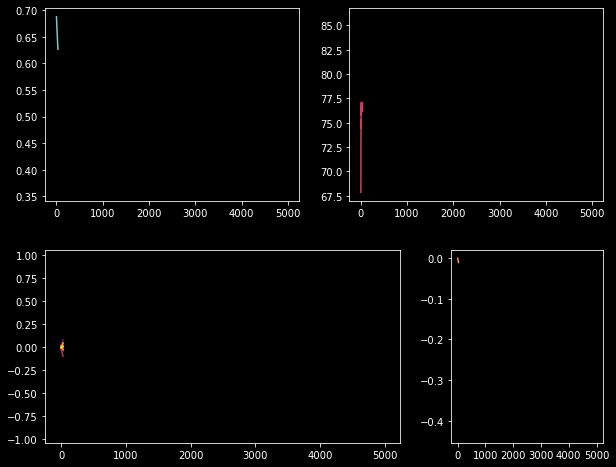

In [10]:


save_path = "/Users/ldallap/Desktop/Github/MachineLearning/example.mp4"

movie_duration = 5
fps = 30


plt.style.use("dark_background")


fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(2, 6, hspace=0.25, wspace=1)

ax1 = fig.add_subplot(gs[0,:3])

ax2 = fig.add_subplot(gs[0, 3:], sharex = ax1)

ax3 = fig.add_subplot(gs[1, :4], sharex = ax1)

ax4 = fig.add_subplot(gs[1, 4:], sharex = ax1)

cost_color = "#78cdbf"
accuracy_color = "#d63a64"
weights_colormap = plt.get_cmap("inferno")
bias_color = "#f59c53"


camera = Camera(fig)
frame_density = int(costs.shape[0] / (movie_duration * fps))

for i in range(0, costs.shape[0], frame_density):

    ax1.plot(np.arange(0,i), costs[:i], c=cost_color)
    ax2.plot(np.arange(0,i), accuracies[:i], c=accuracy_color)

    for _ in range(model.weights.shape[0]):
        ax3.plot(np.arange(0,i), weights[_,:i], c=weights_colormap(_/model.weights.shape[0]))

    ax4.plot(np.arange(0,i), bias[:i], c=bias_color)
    
    camera.snap()
    
animation = camera.animate()
animation.save(save_path, dpi=300, fps=fps,
               progress_callback = lambda i, n:
               print(f'Saving frame {i} of {int(costs.shape[0]/frame_density)}', end="\r"))


plt.show()